# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 


author: davidycliao(David Yen-Chieh Liao)                                                                      
email: davidycliao@gmail.com                                                             
date: 9-July-2021    

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


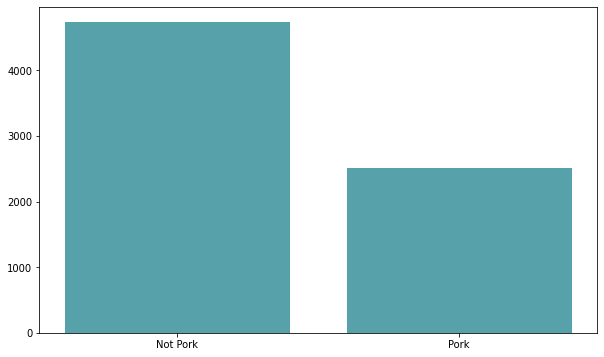

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
pork_plot = pd.DataFrame({"num":data['pork_bill'].value_counts(), "type":['Not Pork','Pork']})
plt.bar(pork_plot['type'], pork_plot['num'], color='#57A1AB')
plt.show()

#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('data/cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)




In [8]:
data_inputs.shape

(7243, 785)

#### (4) Spliting Training / Testing Set

In [9]:
data_labels = data.pork_bill.values

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (4852, 785) 
Shape of X Test : (2391, 785) 
Shape of Y Trian: (4852,) 
Shape of Y Test : (2391,)


In [11]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 4852 
 Not Pork vs Pork: {0: 3167, 1: 1685}


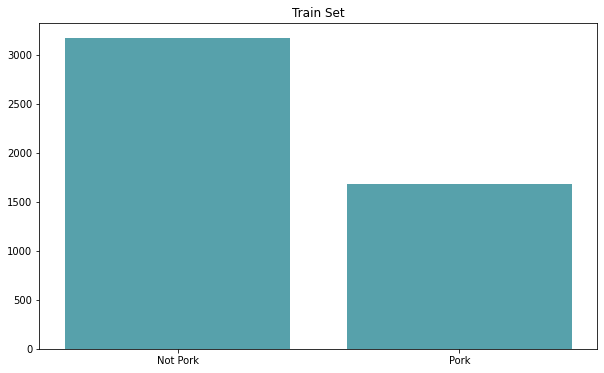

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
train_plot = pd.DataFrame({"num":[dict(zip(unique_train_labels, counts_train_labels))[0],
                                  dict(zip(unique_train_labels, counts_train_labels))[1]], 
                           "type":['Not Pork','Pork']})
plt.bar(train_plot['type'], train_plot['num'], color='#57A1AB')
plt.title('Train Set')
#plt.show()
plt.savefig('images/train_plot.png')

In [13]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 2391 
 Not Pork vs Pork: {0: 1566, 1: 825}


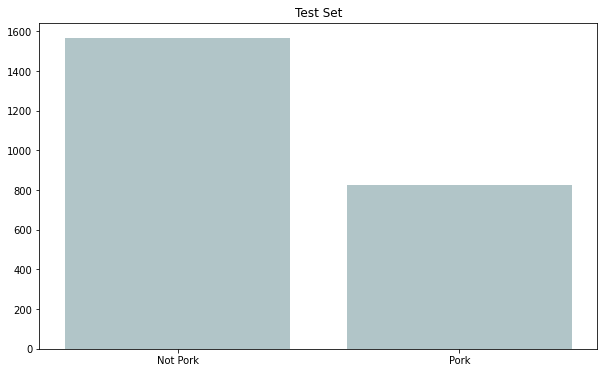

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
test_plot = pd.DataFrame({"num":[dict(zip(unique_test_labels, counts_test_labels))[0],
                                 dict(zip(unique_test_labels, counts_test_labels))[1]], 
                          "type":['Not Pork','Pork']})
plt.bar(test_plot['type'], test_plot['num'], color='#B1C5C8')
plt.title('Test Set')
#plt.show()
plt.savefig('images/test_plot.png')

-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [15]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 # units: Positive integer, dimensionality of the output space.
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="PorkCNN"):
        super(DCNN, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 1, padding="valid", activation="relu")
        self.bigram2 = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 1, padding="valid",activation="relu")
        self.trigram2 = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 2, padding="valid",activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,strides = 2, padding="valid",activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,kernel_size=5,strides = 2, padding="valid",activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_1_1 = self.bigram2(x)
        x_1_1 = self.pool(x_1_1)        
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_2_1 = self.trigram2(x)
        x_2_1 = self.pool(x_2_1)     
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fourgram(x)
        x_4 = self.pool(x_4) 
        x_5 = self.fivegram(x)
        x_5 = self.pool(x_5)      
        merged = tf.concat([x_1,x_1_1, x_2,x_2_1, x_3, x_4, x_5], axis=-1) 
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output

In [16]:
VOCAB_SIZE = tokenizer.vocab_size #tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.25
BATCH_SIZE = 230
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [17]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1], EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "PorkCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  586600    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  80100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  1001

#### (3) Check Point Path

In [18]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [20]:
Dcnn.fit(train_inputs, train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/80
22/22 [==============================] - 45s 2s/step - loss: 0.6161 - accuracy: 0.6441 - val_loss: 0.5237 - val_accuracy: 0.7215
Epoch 2/80
22/22 [==============================] - 42s 2s/step - loss: 0.4010 - accuracy: 0.8285 - val_loss: 0.2754 - val_accuracy: 0.8904
Epoch 3/80
22/22 [==============================] - 44s 2s/step - loss: 0.1920 - accuracy: 0.9270 - val_loss: 0.1785 - val_accuracy: 0.9318
Epoch 4/80
22/22 [==============================] - 42s 2s/step - loss: 0.1010 - accuracy: 0.9676 - val_loss: 0.1609 - val_accuracy: 0.9427
Epoch 5/80
22/22 [==============================] - 39s 2s/step - loss: 0.0614 - accuracy: 0.9815 - val_loss: 0.1608 - val_accuracy: 0.9431
Epoch 6/80
22/22 [==============================] - 40s 2s/step - loss: 0.0475 - accuracy: 0.9854 - val_loss: 0.1860 - val_accuracy: 0.9385
Epoch 7/80
22/22 [==============================] - 40s 2s/step - loss: 0.0484 - accuracy: 0.9856 - val_loss: 0.1745 - val_accuracy: 0.9456
Epoch 8/80
22/22 [==

'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [21]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.616058,0.644064,0.523664,0.721455
1,0.401037,0.828524,0.275381,0.890422
2,0.191959,0.927040,0.178509,0.931828
3,0.101012,0.967642,0.160932,0.942702
4,0.061436,0.981451,0.160843,0.943120
5,0.047501,0.985367,0.186034,0.938519
6,0.048399,0.985573,0.174519,0.945629
7,0.039146,0.986397,0.173419,0.943956
8,0.037828,0.986397,0.176615,0.944375
9,0.049350,0.984130,0.172452,0.947721


<AxesSubplot:>

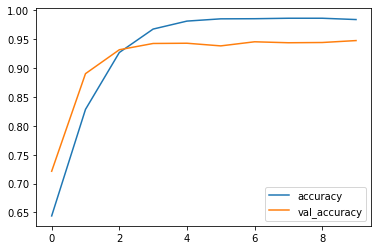

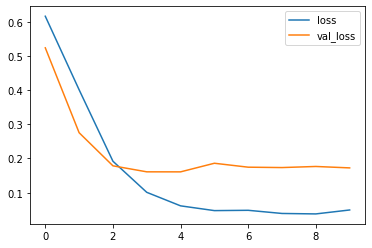

In [22]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

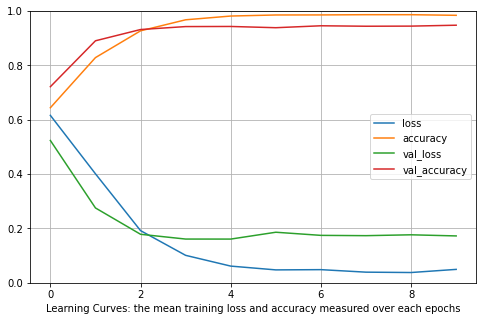

In [23]:
losses.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel("Learning Curves: the mean training loss and accuracy measured over each epochs")
plt.savefig('images/learning_curves3.png')
plt.show()


In [24]:
from sklearn.metrics import classification_report,confusion_matrix
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

11/11 [==============================] - 4s 361ms/step - loss: 0.1725 - accuracy: 0.9477
[0.17245212197303772, 0.9477206468582153]


In [25]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1566
           1       0.95      0.90      0.92       825

    accuracy                           0.95      2391
   macro avg       0.95      0.94      0.94      2391
weighted avg       0.95      0.95      0.95      2391



In [26]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),1526,40
Acutal: Pork (1),85,740


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 2000 samples from Legislative Questions from 6th Session 

In [27]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [28]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
random.seed(42)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Samples

In [29]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
3999,林正峰,0.998658657073975,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額
9892,陳啟昱,0.994998216629028,鑑於現行《所得稅法》第十七條規定特別扣除額教育支出部分，僅以納稅義務人之子女就讀大專院校為限...,所得稅 ; 教育費用 ; 扣除額,所得稅法 ; 特別扣除額 ; 教育支出
1761,彭添富,0.987941861152649,針對「辦理九十四年原住民中低收入戶家庭租屋補助計畫」專案補助計畫，特向行政院提出質詢。,原住民族生活,原住民中低收入戶 ; 租屋補助
7382,盧秀燕,0.987247705459595,針對早期退除役軍官給與補助金發放金額過低，實無法解決終身生活所需，希望相關單位考量實際情況，...,榮民福利,早期退除役軍官給與補助金
2282,曾華德,0.986639261245728,為民國38年至43年間戌守大陳島等地區之中華民國前江、浙、閩、粵反共救國軍補發薪餉問題，攸關...,軍餉,反共救國軍補發薪餉
35,丁守中,0.986229777336121,針就民眾陳情指出，目前政府對身心障礙者提供之生活津貼，依身心障礙程度等級分為1000元至50...,身心障礙者福利,身心障礙者生活津貼
1829,彭紹瑾,0.980291366577148,針對政府為提高生育率，有意將「育嬰假」放寬至全體勞工，並增加六個月的「育嬰留職停薪津貼」，此...,婦女福利,育嬰假 ; 留職停薪津貼
10264,陳根德,0.979950428009033,鑒於桃園縣民眾陳情抗議中正路延伸工程拆遷補償不公，並聚集在中正路尾工地現場，希望盡速發放地上...,道路工程 ; 政府補助,工程 ; 補償
1641,彭添富,0.975777447223663,針對「豪雨成災，農作物損失補償」問題，特向行政院提出質詢。,農業補助,豪雨 ; 農作物
100,丁守中,0.968363046646118,鑒於現行「國軍退除役官兵就養安置辦法」中規定，合於領取每月一三、三五○元榮民就養金的榮民，在...,榮民福利,榮民就養金 ; 喪葬補助 ; 遺眷


##### Last 10 Rows of 2000 Samples

In [30]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
7674,羅世雄,0.000008172279195,針對手機通訊業者辦理新辦戶及更換SIM卡程序中，出現犯罪集團持偽造身分證，藉此竊取個人資料，...,電信行政 ; 國民身分證 ; 隱私權 ; 偽造,手機 ; 竊取個人資料 ; 犯罪集團
10798,黃敏惠(離職),0.000007924887541,就近日來爆發知名提神飲料遭下毒事件，已知有四位台中市民因誤喝中毒，並有一人已不治死亡。此一類...,飲料 ; 中毒,飲料 ; 下毒 ; 千面人
2439,李俊毅,0.000007635978363,針對近來國務機要費與首長特別費因相關規範未臻明確，遭質疑該筆金額等同於首長薪水或私房錢，且有...,國家元首 ; 行政首長 ; 統一發票,國務機要費 ; 首長特別費
9039,邱毅,0.000007290207577,針對新聞局認定TVBS應為綜合台非新聞台乙案，準備將TVBS轉頻一事，日前行政院新聞局認定T...,新聞自由 ; 電視臺,TVBS ; 股權結構 ; 外資 ; 國家通訊傳播委員會組織法 ; NCC ; 報導自由
716,吳敦義,0.000005977188721,針對新聞局長謝志偉於立院議場備詢時，被要求下台，卻堅不下台一事，顯示行政院對憲法之基本尊重全...,政務官 ; 立法院,新聞局長謝志偉 ; 立院議場
6347,王幸男,0.000005814045380,針對本院交通委員會在台中市長夫人邵曉鈴女士車禍事件之後，以超高的效率通過了「道路交通管理處罰...,交通規則,道路交通管理處罰條例 ; 安全帶
6091,王幸男,0.000005248836715,針對道路人孔蓋或管線挖掘後回填品質不佳，或是公共安全沒有做好，導致各種傷害和死亡案件，一直居...,公共安全,人孔蓋 ; 公共安全 ; 道路品質
1299,廖婉汝,0.000004947882644,針對近來警界風紀事件頻傳，身為人民保母的員警卻屢屢傳出知法犯法、違法亂紀的情形，嚴重侵害到人...,警察風紀,警界風紀
3485,林德福,0.000002930427627,針對國內毒品市場再見新玩意，表示關切！一種名為「Ｎｅｘｕｓ」新興毒品，已入侵台灣。這種俗稱「...,毒品,毒品 ; Ｎｅｘｕｓ
3525,林惠官,0.000002737399427,對於政府要求台灣郵政公司每天挑選數萬封郵件蓋上台灣入聯的戳章一事，表示高度關切與嚴正的抗議！...,郵政機關 ; 政令宣導,台灣郵政公司 ; 台灣入聯


#### (2) Export an End-to-end Model


In [31]:
from tensorflow.keras.models import load_model

In [32]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [33]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')